<a href="https://colab.research.google.com/github/SaverioMonaco/ImageColorization/blob/master/SmallTest_Birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Recoloring: Small test

In [1]:
!ls

sample_data


In [2]:
# Download and extract

!gdown https://drive.google.com/u/0/uc?id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45&export=download

import tarfile
tar = tarfile.open("CUB_200_2011.tgz")
tar.extractall()
tar.close()

!mkdir birds

# For this small version, I selected a small dataset containing only yellow birds
!mv CUB_200_2011/images/020.Yellow_breasted_Chat/*.jpg birds
!mv CUB_200_2011/images/043.Yellow_bellied_Flycatcher/*.jpg birds
!mv CUB_200_2011/images/047.American_Goldfinch/*.jpg birds
!mv CUB_200_2011/images/055.Evening_Grosbeak/*.jpg birds
!mv CUB_200_2011/images/077.Tropical_Kingbird/*.jpg birds
!mv CUB_200_2011/images/088.Western_Meadowlark/*.jpg birds
!mv CUB_200_2011/images/095.Baltimore_Oriole/*.jpg birds
!mv CUB_200_2011/images/096.Hooded_Oriole/*.jpg birds
!mv CUB_200_2011/images/174.Palm_Warbler/*.jpg birds
!mv CUB_200_2011/images/182.Yellow_Warbler/*.jpg birds


# Move every photo to the dataset folder, if you want a bigger one
#!mv CUB_200_2011/images/*/*.jpg birds

Permission denied: https://drive.google.com/u/0/uc?id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45
Maybe you need to change permission over 'Anyone with the link'?
sample_data


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir birds
!cp /content/gdrive/MyDrive/smallbirds/*/*.jpg birds

Mounted at /content/gdrive
^C


In [7]:
# Move data into training and validation directories
import os

# Make the folders
os.makedirs('images/train/class/', exist_ok=True)
os.makedirs('images/val/class/', exist_ok=True)

for i, file in enumerate(os.listdir('birds')):
  if i < int(len(os.listdir('birds'))*0.2): # first 20% will be val
    os.rename('birds/' + file, 'images/val/class/' + file)
  else: # others will be in train
    os.rename('birds/' + file, 'images/train/class/' + file)

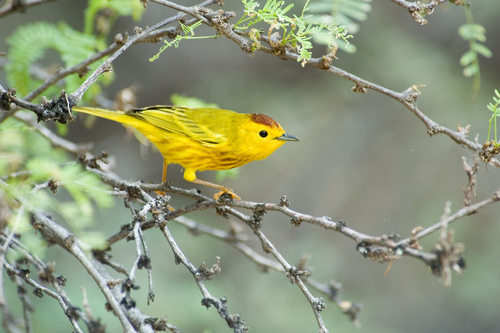

In [8]:
# Make sure the images are there
from IPython.display import Image, display
# Display first photo of train dataset
display(Image(filename='images/train/class/' + os.listdir('images/train/class/')[0]))


In [9]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io

# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F

# For our model
import torchvision.models as models
from torchvision import datasets, transforms

# For utilities
import os, shutil, time

In [10]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()
if use_gpu:
  print('You are using GPU')

In [11]:
# NET CLASS
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(pretrained=True) #num_classes=365,
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):
    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [12]:
model = ColorizationNet()
# You are downloading the first half pretrained ResNet

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [13]:
criterion = nn.MSELoss()

In [14]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

# Next we define transforms for our training and validation data.

# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train' , train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [15]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [16]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [17]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 50 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [18]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [19]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 2e2

In [20]:
# Train model
epochs = 50
loss_arr = []

for epoch in range(epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=.0)
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
    loss_arr.append(losses)
  #Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0][0/8]	Time 17.692 (17.692)	Data 1.805 (1.805)	Loss 0.6494 (0.6494)	


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-ac648b073f72>", line 8, in <module>
    train(train_loader, model, criterion, optimizer, epoch)
  File "<ipython-input-17-1206982078b1>", line 18, in train
    output_ab = model(input_gray)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-11-db2c04181e2b>", line 39, in forward
    output = self.upsample(midlevel_features)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py", line 139, in forward
    input = module(input)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module

KeyboardInterrupt: ignored

In [ ]:
plt.plot(np.arange(epochs),loss_arr,'o-')

In [ ]:
torch.save(model.state_dict(), '/content/model.pth')

In [ ]:
# Load model
pretrained = torch.load('/content/model.pth')
model.load_state_dict(pretrained)

In [ ]:
# Validate
save_images = True
with torch.no_grad():
  validate(val_loader, model, criterion, save_images, 0)

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-4-epoch-'+str(epochs - 1)+'.jpg', 'outputs/gray/img-4-epoch-'+str(epochs - 1)+'.jpg'),
               ('outputs/color/img-5-epoch-'+str(epochs - 1)+'.jpg', 'outputs/gray/img-5-epoch-'+str(epochs - 1)+'.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
image_orig = cv2.imread('/content/outputs/gray/img-9-epoch-'+str(epochs - 1)+'.jpg')
image = cv2.imread('/content/outputs/color/img-9-epoch-'+str(epochs - 1)+'.jpg')

alpha = 1.5 # Contrast control (1.0-3.0)
#beta = 0 # Brightness control (0-100)

adjusted = cv2.convertScaleAbs(image, alpha=1.5, beta=0)
w,h = 300,300
image_orig = cv2.resize(image_orig, (w,h))  #resize images
image = cv2.resize(image, (w,h))
adjusted = cv2.resize(adjusted, (w,h))

cv2_imshow(image_orig)
cv2_imshow(image)
cv2_imshow(adjusted)
#cv2.waitKey()